<a href="https://colab.research.google.com/github/AilingLiu/Growth_Analysis/blob/master/Customer_Retention_Rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
import warnings
warnings.filterwarnings(action="ignore")

In [2]:
url='https://github.com/AilingLiu/Growth_Analysis/blob/master/Data/online_retail.csv?raw=true'

def load_data(link=url):
  return pd.read_csv(url, encoding = 'unicode_escape')

def add_features(df):

  if not set(['InvoiceDate', 'CustomerID', 'Quantity', 'UnitPrice']) <= set(df.columns):
    print('You do not have the needed columns.')
    return df
  
  newdf = df.copy()
  newdf['InvoiceDate']=pd.to_datetime(newdf['InvoiceDate'])
  newdf['InvoiceYM']=newdf['InvoiceDate'].apply(lambda x: x.strftime('%Y%m'))
  newdf['Revenue'] = newdf['UnitPrice'] * newdf['Quantity']
  minyearmonth = newdf.groupby(['CustomerID'])['InvoiceDate'].min().apply(lambda x: x.strftime('%Y%m')).to_frame('MinYearMonth')
  newdf=newdf.join(minyearmonth, on='CustomerID')
  newdf['CustomerType'] = np.where(newdf['InvoiceYM'] == newdf['MinYearMonth'], 'New', 'Exist')
  return newdf

data = load_data()
retail=add_features(data)
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYM,Revenue,MinYearMonth,CustomerType
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,15.30,201012,New
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34,201012,New
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,22.00,201012,New
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34,201012,New
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34,201012,New


we will create a new index as cohortid to show how many months passed since the first transaction (month). A group of customer has the same first transaction month is considered to be the same cohort, denoted by the transaction month directly. We are interested to see the percentegae of customers remains as time past by first transaction.

In [0]:
def get_year_month(col, format='%Y%m'):
  year =  pd.to_datetime(col, format=format).dt.year
  month = pd.to_datetime(col, format=format).dt.month
  return year, month

inv_year, inv_month = get_year_month(retail['InvoiceYM'])
signup_year, signup_month = get_year_month(retail['MinYearMonth'])
retail['cohortid'] =(inv_year-signup_year)*12 + (inv_month-signup_month)+1

In [6]:
grouping_count = retail.groupby(['InvoiceYM', 'cohortid'])
cohort_data = grouping_count['CustomerID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()

cohort_counts = cohort_data.pivot(index='InvoiceYM',
                                  columns='cohortid',
                                  values='CustomerID')

newdf = pd.DataFrame(index=cohort_counts.index)
for i in range(len(cohort_counts)):
  newdf = newdf.join(cohort_counts.iloc[:, i].shift(-i))

newdf

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
InvoiceYM,,,,,,,,,,,,,
201012,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
201101,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
201102,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
201103,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
201104,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN
201105,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,NaN,NaN,NaN,NaN,NaN
201106,235.0,49.0,44.0,64.0,58.0,79.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
201107,191.0,40.0,39.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201108,167.0,42.0,42.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
retention_rate = newdf.divide(newdf.iloc[:, 0], axis=0).round(2)
retention_rate

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
InvoiceYM,,,,,,,,,,,,,
201012,1.0,0.38,0.33,0.39,0.36,0.40,0.38,0.35,0.35,0.39,0.37,0.50,0.27
201101,1.0,0.24,0.28,0.24,0.33,0.30,0.26,0.26,0.31,0.35,0.37,0.15,NaN
201102,1.0,0.25,0.19,0.28,0.27,0.25,0.26,0.28,0.26,0.31,0.09,NaN,NaN
201103,1.0,0.19,0.25,0.22,0.23,0.18,0.26,0.24,0.29,0.09,NaN,NaN,NaN
201104,1.0,0.23,0.22,0.21,0.21,0.24,0.23,0.26,0.08,NaN,NaN,NaN,NaN
201105,1.0,0.24,0.17,0.17,0.22,0.24,0.27,0.10,NaN,NaN,NaN,NaN,NaN
201106,1.0,0.21,0.19,0.27,0.25,0.34,0.10,NaN,NaN,NaN,NaN,NaN,NaN
201107,1.0,0.21,0.20,0.23,0.27,0.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201108,1.0,0.25,0.25,0.25,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


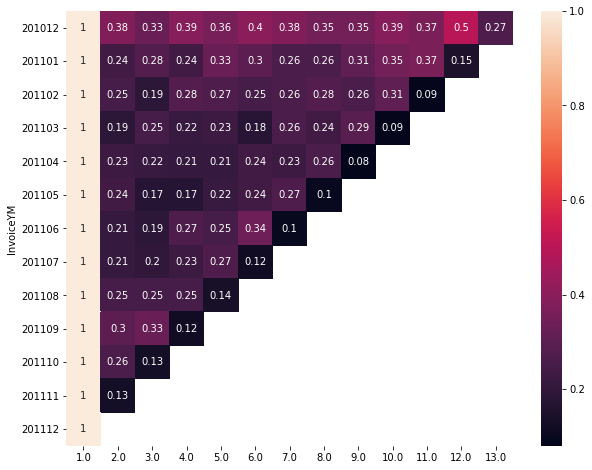

In [8]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(retention_rate, annot=True)
plt.show()

In [0]:
retention_rate.iloc[:, 1:].mean(axis=1).sort_values(ascending=False)

InvoiceYM
201012    0.372500
201101    0.280909
201109    0.250000
201102    0.244000
201106    0.226667
201108    0.222500
201103    0.216667
201104    0.210000
201107    0.206000
201105    0.201429
201110    0.195000
201111    0.130000
201112         NaN
dtype: float64

The first cohort is `201012`. In the first transaction month, i.e.`id=1`, the retention is 100%. In the second month, denoted by `id=2`, the retetion rate drops to 0.38. The retention rate was fluctuating among some of the months, ending at 0.27 at the 13th month. This cohort has the highest average monthly retention rate.

The lowest retention rate is 0.08 from cohort `201104`. There are only 8% of this group of customers left at its 9th transaction month.